In [1]:
import numpy as np
import Pk_library as PKL
import matplotlib.pyplot as plt
import camb
import h5py as h5

In [2]:
def compute_pk(delta, boxsize=1000, MAS='CIC'):

    Pk = PKL.Pk(delta.astype(np.float32), boxsize, axis=0, MAS=MAS, threads=1, verbose=False)
    k3D      = Pk.k3D
    Pk3D     = Pk.Pk[:,0]
    
    return k3D, Pk3D


def compute_crossk(delta1, delta2, boxsize=1000, MAS=['CIC','CIC']):
    
    Pk = PKL.XPk([delta1.astype(np.float32),delta2.astype(np.float32)], boxsize, 0, MAS=MAS, threads=1)
    
    k      = Pk.k3D
    Pk0_1  = Pk.Pk[:,0,0]  #monopole of field 1
    Pk0_2  = Pk.Pk[:,0,1]  #monopole of field 2
    Pk0_X  = Pk.XPk[:,0,0] #monopole of 1-2 cross P(k)
    
    r = Pk0_X / np.sqrt(Pk0_1 * Pk0_2)
    
    return k, Pk0_1, Pk0_2, r


Computing power spectra of the fields...
Time FFTS = 0.08
Time loop = 0.06
Time taken = 0.15 seconds
As from camb 4.636566433404602e-09


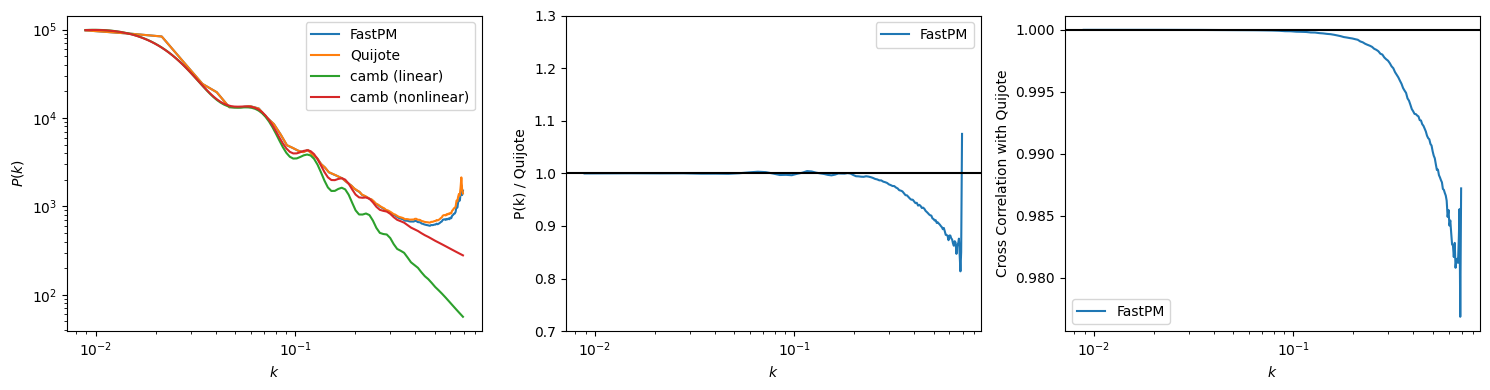

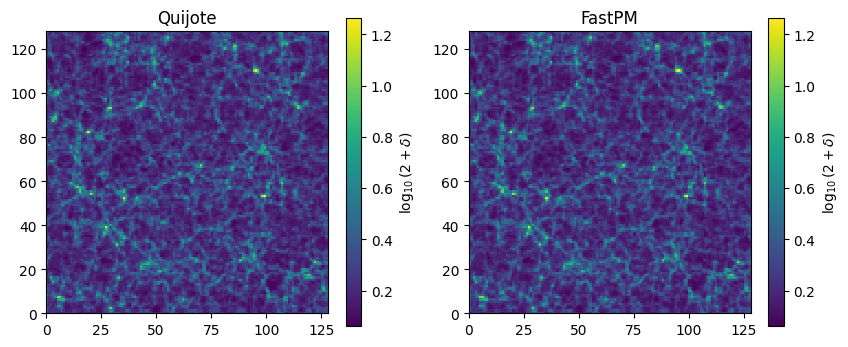

In [3]:
simnum = 0
N = 128

Om, Ob, h, ns, sigma8 = np.loadtxt('/home/mattho/data/quijote/latin_hypercube_params.txt')[simnum,:]

quijote_field = np.load(f'/home/mattho/data/quijote/density_field/latin_hypercube/{simnum}/df_m_{N}_z=0.npy')

with h5.File('/data101/bartlett/ili/cmass/fastpm_1gpch_z0.0/fastpm/L1000-N128/0/nbody.h5', 'r') as h5file:
    fastpm_field  = np.array(h5file['1.000000']['rho'])
    fastpm_field = fastpm_field / fastpm_field.mean() - 1

k, Pk0_fastpm, Pk0_quijote, rfastpm = compute_crossk(fastpm_field, quijote_field)

# Get linear and non-linear P(k) with camb
pars = camb.CAMBparams(DoLensing=False)
pars.set_cosmology(H0 = h*100,
                   ombh2 = Ob * h ** 2,
                   omch2 = (Om - Ob) * h ** 2,
                   mnu = 0.0,
                   omk = 0,
                   # tau=tau,
                  )
As_fid = 2.0e-9
pars.InitPower.set_params(As=As_fid, ns=ns, r=0)
pars.set_matter_power(redshifts=[0.0], kmax=k[-1])
pars.NonLinear = camb.model.NonLinear_none
results = camb.get_results(pars)
sigma8_camb = results.get_sigma8()[0]
As_new = (sigma8 / sigma8_camb) ** 2 * As_fid
print('As from camb', As_new)
pars.InitPower.set_params(As=As_new, ns=ns, r=0)
results = camb.get_results(pars)
kh_lin, z, pk_camb_lin = results.get_matter_power_spectrum(
                        minkh=k.min(), maxkh=k.max(), npoints=len(k))
pk_camb_lin = pk_camb_lin[0,:]
pars.NonLinear = camb.model.NonLinear_both
pars.NonLinearModel.set_params(halofit_version='takahashi')
results = camb.get_results(pars)
kh_nonlin, z, pk_camb_nonlin = results.get_matter_power_spectrum(
                        minkh=k.min(), maxkh=k.max(), npoints=len(k))
pk_camb_nonlin = pk_camb_nonlin[0,:]


fig, axs = plt.subplots(1, 3, figsize=(15,4))
axs[0].loglog(k, Pk0_fastpm, label='FastPM')
axs[0].loglog(k, Pk0_quijote, label='Quijote')
axs[0].loglog(kh_lin, pk_camb_lin, label='camb (linear)')
axs[0].loglog(kh_nonlin, pk_camb_nonlin, label='camb (nonlinear)')
axs[0].set_ylabel(r'$P(k)$')
axs[1].semilogx(k, Pk0_fastpm / Pk0_quijote, label='FastPM')
axs[1].axhline(1, color='k')
axs[1].set_ylabel('P(k) / Quijote')
axs[1].set_ylim(0.7, 1.3)
axs[2].semilogx(k, rfastpm, label='FastPM')
axs[2].axhline(1, color='k')
axs[2].set_ylabel('Cross Correlation with Quijote')
for ax in axs:
    ax.set_xlabel(r'$k$')
    ax.legend()
fig.tight_layout()

fig, axs = plt.subplots(1, 2, figsize=(10,4))

vmin = np.amin(np.log10(2 + fastpm_field[N//2]))
vmax = np.amax(np.log10(2 + fastpm_field[N//2]))

pc = axs[0].pcolor(np.log10(2 + quijote_field[N//2]), vmin=vmin, vmax=vmax)
cb = fig.colorbar(pc, ax=axs[0])
cb.set_label(r'$\log_{10}(2 + \delta)$')
axs[0].set_title('Quijote')

pc = axs[1].pcolor(np.log10(2 + fastpm_field[N//2]))#, vmin=vmin, vmax=vmax)
cb = fig.colorbar(pc, ax=axs[1])
cb.set_label(r'$\log_{10}(2 + \delta)$')
axs[1].set_title('FastPM')

for ax in axs:
    ax.set_aspect('equal')